# Importing Libraries and Data

In [1]:
import pyiast
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import time
import os
import scipy.optimize as optim
import matplotlib.pyplot as plt



df_NAME=pd.read_csv("HEAT_1222_VSA_re.csv")

bins_H2S = []
for nam in df_NAME["NAME"]:
    NAM=str(nam)
    f_tmp = open("iso_"+NAM+"_saved.bin",'rb')
    bin_tmp = pickle.load(f_tmp)
    bins_H2S.append(bin_tmp)
    f_tmp.close()
    
bins_CO2 = []
for nam in df_NAME["NAME"]:
    NAM=str(nam)
    f_tmp = open("iso_"+NAM+"_saved.bin",'rb')
    bin_tmp = pickle.load(f_tmp)
    bins_CO2.append(bin_tmp)
    f_tmp.close()

Names_CO2=df_NAME["NAME"].to_numpy()
Name_list=Names_CO2
Names_H2S=df_NAME["NAME"].to_numpy()
dH_CO2 = np.array([df_NAME["SF6_HEAT"],df_NAME["N2_HEAT"]]).T
dH_H2S = np.array([df_NAME["SF6_HEAT"],df_NAME["N2_HEAT"]]).T

In [2]:
print(Name_list)

[  12   77   80  101  122  124  167  193  208  382  383  384  387  458
  480  555  664  668  678  679  680  795  801  802  833  917 1161 1182
 1217 1238 1326 1340 1395 1426 1557 1600 1634 1659 1664 1677 1691 1701
 1703 1706 1722 1739 1781 1854 1901 1929 1948 1954 1961 2064 2066 2153
 2199 2234 2278 2282 2283 2284 2292 2297 2440 2458 2459 2495 2510 2521
 2839 2855 2860 2861 2866 2872 2874 2877 2880 2883 2884 2885 2887 2888
 2889 2890]


In [3]:
Arrh = lambda T,dH ,T_ref: np.exp(-dH/8.3145*(1/T - 1/T_ref)) # Arrhenius equation (Clasius-Clapeyron Equation)

## Isothermal mixture isotherm
def iso_mix(P_par, T, iso_list, dH_list,Tref_list):
    P_norm = []
    for (p,dh,tref) in zip(P_par, dH_list,Tref_list):
        p_n = Arrh(T,dh,tref)*p 
        P_norm.append(p_n)
    P_norm_arr = np.array(P_norm)
    #print(P_norm_mat.T)
    if P_norm_arr.ndim > 1:
        for i in range(len(P_norm[0])):
            p_tmp = P_norm_arr[i,:]
            p_tmp[p_tmp<0.000001] = 0.000001
            q_IAST_tmp = pyiast.iast(p_tmp,
                                     iso_list,
                                     warningoff=True)
    else:
        try:
            p_tmp = P_norm_arr
            p_tmp[p_tmp<0.000001] = 0.000001
            #print(p_tmp)
            q_IAST_tmp = pyiast.iast(p_tmp,
                                    iso_list,
                                     warningoff=True)
        except:    
            try:
                #print('Initial guess error with P = ',P_par)
                x_IG = np.ones(len(p_tmp))/len(p_tmp)
                q_IAST_tmp = pyiast.iast(p_tmp,
                                        iso_list,adsorbed_mole_fraction_guess = x_IG,
                                        warningoff=True)
            except:
                try:
                    arg_min = np.argmin(p_tmp)
                    p_tmp[p_tmp<0.000001] = 0.000001
                    x_IG = 0.05*np.ones(len(p_tmp))
                    x_IG[arg_min] = 1 - 0.05*(len(p_tmp)-1)
                    #print(x_IG)
                    q_IAST_tmp = pyiast.iast(p_tmp,
                                            iso_list,adsorbed_mole_fraction_guess = x_IG,
                                            warningoff=True)

                except:
                    try:
                        arg_max = np.argmax(p_tmp)
                        p_tmp[p_tmp<0.000001] = 0.000001
                        x_IG = 0.05*np.ones(len(p_tmp))
                        x_IG[arg_max] = 1 - 0.05*(len(p_tmp)-1)
                        #print(x_IG)
                        q_IAST_tmp = pyiast.iast(p_tmp,
                                                iso_list,adsorbed_mole_fraction_guess = x_IG,
                                                warningoff=True)        
                    except:
                        try:
                            arg_max = np.argmax(p_tmp)
                            p_tmp[p_tmp<0.000001] = 0.000001
                            x_IG = 0.15*np.ones(len(p_tmp))
                            x_IG[arg_max] = 1 - 0.15*(len(p_tmp)-1)
                            #print(x_IG)
                            q_IAST_tmp = pyiast.iast(p_tmp,
                                                iso_list,adsorbed_mole_fraction_guess = x_IG,
                                                warningoff=True)
                        except:
                            try:
                                arg_min = np.argmin(p_tmp)
                                p_tmp[p_tmp<0.000001] = 0.000001
                                x_IG = 0.01*np.ones(len(p_tmp))
                                x_IG[arg_min] = 1 - 0.01*(len(p_tmp)-1)
                                #print(x_IG)
                                q_IAST_tmp = pyiast.iast(p_tmp,
                                            iso_list,adsorbed_mole_fraction_guess = x_IG,
                                            warningoff=True)

                            except:
                                arg_max = np.argmax(p_tmp)
                                p_tmp[p_tmp<0.000001] = 0.000001
                                x_IG = 0.01*np.ones(len(p_tmp))
                                x_IG[arg_max] = 1 - 0.01*(len(p_tmp)-1)
                                #print(x_IG)
                                q_IAST_tmp = pyiast.iast(p_tmp,
                                                iso_list,adsorbed_mole_fraction_guess = x_IG,
                                            warningoff=True)                                
           
    return q_IAST_tmp

In [4]:
def sat_fraction(y_lead,q_lead_array, y_follow,q_follow_array):
    q_sat_lead_part, q_sat_lead_tot, q_des_lead = q_lead_array
    q_sat_fo, q_des_fo = q_follow_array
    numo = y_follow*(q_sat_lead_part - q_des_lead)+y_lead*q_des_fo
    denom = y_follow*(q_sat_lead_part - q_sat_lead_tot)+y_lead*q_sat_fo
    sat_frac = numo/denom
    return sat_frac

In [5]:
def x2x(x_ini,P_high,P_low,
        iso_input, dH_input, Tref_input, 
        yfeed,Tfeed):
    iso_1 = iso_input[0] # Ethane (C2H6)
    iso_2 = iso_input[1] # Ethylene (C2H4)
    iso  = [iso_1,iso_2]
    dH_1, dH_2 = dH_input[:2]         # (kJ/mol): Heat of adsorption
    dH = np.array([dH_1,dH_2])*1000    # (J/mol): Heat of adsorption 
    P_low_part = np.array(x_ini)*P_low      # (bar): partial pressure
    P_high_part = np.array(yfeed)*P_high    # (bar): partial pressure
    ### Uptakes
    #print(P_low_part)
    P_low_part = np.reshape(P_low_part,len(iso))
    q_des = iso_mix(P_low_part,Tfeed,iso,
                    dH,Tref_input)
    #print(P_high_part)
    P_high_part = np.reshape(P_high_part,len(iso))
    q_sat_tot = iso_mix(P_high_part,Tfeed,iso,
                        dH,Tref_input)
    Dq_tot = q_sat_tot-q_des
    ### Leading component ?
    sat_extent = np.array(yfeed)/Dq_tot # Saturation extent kg/mol
    ind_lead_tot = np.argmax(sat_extent)
    dq = q_sat_tot - q_des
    x_out = dq/(np.sum(dq))
    return x_out,ind_lead_tot



def rec(x_ini,P_high,P_low,
        iso_input, dH_input, Tref_input, 
        yfeed,Tfeed):
    def x_err(xx):
        x_new,i_lead = x2x([xx, 1-xx],P_high,P_low,
                           iso_input, dH_input, Tref_input, 
                           yfeed,Tfeed)
        return (xx-x_new[0])**2
    #sol = optim.minimize(x_err,x_ini,method='COBYLA')
    sol = optim.least_squares(x_err,x_ini,bounds = [0,1])
    x_sol = sol.x
    _,i_lead = x2x([x_sol, 1- x_sol],P_high,P_low,
                   iso_input, dH_input, Tref_input, 
                   yfeed,Tfeed)
    #if i_lead  < 0.5:
    #    return -1
    Recovery = 1-(1-x_sol)/x_sol*yfeed[0]/yfeed[1]
    if Recovery < 0 or Recovery > 1:
        Recovery = 1-x_sol/(1-x_sol)*yfeed[1]/yfeed[0]
 #   return Recovery, i_lead, x_sol+
    return Recovery, i_lead, x_sol





In [7]:
T_feed_in = 313         # (K) temperature or 298K
T_tri = [298.15,]*2
#y_feed_in = np.array([0.83356,0.1644])
y_ethy = 9/10
#y_ethy = 0.83356
y_feed_in = np.array([1-y_ethy,y_ethy])
Rec_list_set = []
xx_list_set = []
leading_index_set = []
#Pl_list = np.linspace(0.004,0.5,30)
Pl_list = 1/(10**np.linspace(0.5,3,101))

for binn,dH,nam in zip(bins_CO2,dH_CO2,Name_list):
    Rec_list = []
    x_list = []
    leading_index = []
    
    for pl in Pl_list:
        try:
            x_guess = 0.05
            rec_tmp,l_ind,x_tmp = rec(x_guess, 1,pl,
                                      binn, dH, T_tri,y_feed_in, T_feed_in)
        except:
            try:
                x_guess = 0.4
                rec_tmp,l_ind,x_tmp = rec(x_guess, 1,pl,
                                          binn, dH, T_tri,y_feed_in, T_feed_in)
            except:
                try:
                    x_guess = 0.8
                    rec_tmp,l_ind,x_tmp = rec(x_guess, 1,pl,
                                              binn, dH, T_tri,y_feed_in, T_feed_in)                        
                except:
                    try:
                        x_guess = 0.9
                        rec_tmp,l_ind,x_tmp = rec(x_guess, 1,pl,
                                                  binn, dH, T_tri,y_feed_in, T_feed_in)                        
                    except:
                        try:
                            x_guess = 0.95
                            rec_tmp,l_ind,x_tmp = rec(x_guess, 1,pl,
                                                      binn, dH, T_tri,y_feed_in, T_feed_in)                        
                        except:
                            x_guess = 0.98
                            rec_tmp,l_ind,x_tmp = rec(x_guess, 1,pl,
                                                      binn, dH, T_tri,y_feed_in, T_feed_in)
                        
        #x_guess[0] = x_tmp*1.01
        Rec_list.append(rec_tmp)
        x_list.append(x_tmp[0])
        leading_index.append(l_ind)
    Rec_list_set.append(Rec_list)
    xx_list_set.append(x_list)
    leading_index_set.append(leading_index)
    print(nam)
    #print(Rec_list[-1])
    print(x_tmp)
    

12
[0.70862901]


C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)


77
[0.95545071]
80
[0.8474821]
101
[0.84410923]
122
[0.97196645]
124
[0.9356987]
167
[0.86334373]
193
[0.8865966]
208
[0.86674262]
382
[0.97517533]
383
[0.9753248]
384
[0.95293065]
387
[0.85878846]
458
[0.9068536]
480
[0.97925771]
555
[0.94943752]
664
[0.92954229]
668
[0.92371858]
678
[0.87067342]
679
[0.84791498]
680
[0.88184642]
795
[0.9641299]
801
[0.87912673]
802
[0.87439801]
833
[0.79622705]
917
[0.91943493]
1161
[0.85045146]
1182
[0.52996701]
1217
[0.94469046]
1238
[0.94455162]
1326
[0.90980204]
1340
[0.81731956]
1395
[0.88424344]
1426
[0.83776473]
1557
[0.90685324]
1600
[0.78592091]
1634
[0.87760964]
1659
[0.9273254]


C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:354: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["Ka"] * pressure


1664
[0.97363637]
1677
[0.93337449]
1691
[0.72086948]
1701
[0.94199734]
1703
[0.87630618]
1706
[0.87388256]
1722
[0.9108112]
1739
[0.76304698]
1781
[0.82898281]
1854
[0.96514636]
1901
[0.95720242]
1929
[0.7966567]
1948
[0.8606324]
1954
[0.84819665]
1961
[0.69028922]
2064
[0.89674369]
2066
[0.86608172]
2153
[0.97693159]
2199
[0.96158392]
2234
[0.94431912]
2278
[0.83785627]
2282
[0.89166579]
2283
[0.88015488]
2284
[0.87590934]
2292
[0.90456753]
2297
[0.92368572]
2440
[0.89232701]
2458
[0.95170169]
2459
[0.97461149]
2495
[0.9577472]
2510
[0.92764018]
2521
[0.92519154]
2839
[0.89424496]
2855
[0.90589696]
2860
[0.94102971]
2861
[0.81693791]
2866
[0.92441605]
2872
[0.80409821]
2874
[0.93705287]
2877
[0.74909626]
2880
[0.57320513]
2883
[0.54409676]
2884
[0.8421099]
2885
[0.84062551]
2887
[0.81840191]
2888
[0.70636283]
2889
[0.74151729]
2890
[0.92848646]


In [8]:
for i in range(len(Name_list)):
    print(i, Name_list[i])

0 12
1 77
2 80
3 101
4 122
5 124
6 167
7 193
8 208
9 382
10 383
11 384
12 387
13 458
14 480
15 555
16 664
17 668
18 678
19 679
20 680
21 795
22 801
23 802
24 833
25 917
26 1161
27 1182
28 1217
29 1238
30 1326
31 1340
32 1395
33 1426
34 1557
35 1600
36 1634
37 1659
38 1664
39 1677
40 1691
41 1701
42 1703
43 1706
44 1722
45 1739
46 1781
47 1854
48 1901
49 1929
50 1948
51 1954
52 1961
53 2064
54 2066
55 2153
56 2199
57 2234
58 2278
59 2282
60 2283
61 2284
62 2292
63 2297
64 2440
65 2458
66 2459
67 2495
68 2510
69 2521
70 2839
71 2855
72 2860
73 2861
74 2866
75 2872
76 2874
77 2877
78 2880
79 2883
80 2884
81 2885
82 2887
83 2888
84 2889
85 2890


In [9]:
Rec_sort_tmp = []
for i in range(len(Rec_list_set)):
    rec_tmm = np.reshape(np.array(Rec_list_set[i]),[-1])
    Rec_sort_tmp.append(rec_tmm)
Rec_sort_tmp = np.array(Rec_sort_tmp)

Sort_target = np.reshape(np.array(Rec_sort_tmp)[:,-1],-1)
#print(Sort_target)
arg_st = np.argsort(Sort_target)[::-1]
Name_sort = np.array(Name_list)[arg_st]

Rec_sort = Rec_sort_tmp[arg_st,:]
leading_sort = np.array(leading_index_set)[arg_st]
#is_exp_sort = is_exp[arg_st]

print(Pl_list[-5]*100)
print(Name_sort)
print(Rec_sort[:,-5])

0.1778279410038923
[ 480 2153  383  382 2459 1664  122 1854  795 2199 2495 1901   77  384
 2458  555 1217 1238 2234 1701 2860 2874  124 1677  664 2890 2510 1659
 2521 2866  668 2297  917 1722 1326  458 1557 2855 2292 2064 2839 2440
 2282  193 1395  680 2283  801 1634 1703 2284  802 1706  678  208 2066
  167 1948  387 1161 1954  679   80  101 2884 2885 2278 1426 1781 2887
 1340 2861 2872 1929  833 1600 1739 2877 2889 1691   12 2888 1961 2880
 2883 1182]
[0.99726214 0.9972989  0.99670844 0.99678355 0.99692946 0.99668018
 0.99670251 0.99579144 0.99572325 0.99547576 0.9949739  0.99495371
 0.99466185 0.99440122 0.99431802 0.9939722  0.99340441 0.99336688
 0.99331788 0.99305555 0.99287819 0.99225829 0.9921891  0.99195836
 0.99144031 0.99130464 0.99119297 0.99117271 0.99088721 0.99070506
 0.99069851 0.99069341 0.99009725 0.98898478 0.98886101 0.98848025
 0.98845045 0.9882913  0.98815236 0.98706255 0.98669654 0.9863806
 0.98641503 0.98566677 0.98532919 0.98498512 0.98478512 0.98458357
 0.98435

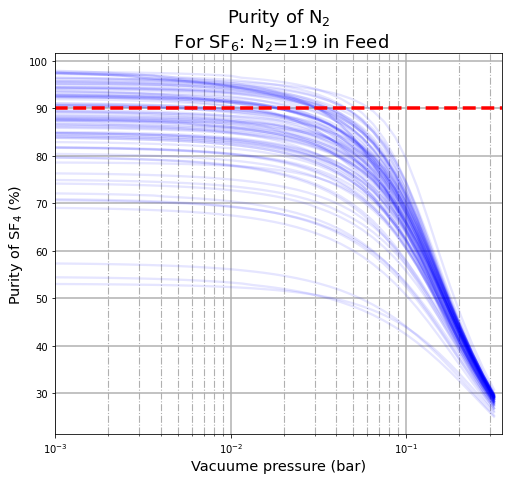

In [13]:
line_len = [1,2,4]
space_len = [1,2,4]
l_style = [(0,())]
for line in line_len:
    for space in space_len:
        style_temp = (line, space)
        l_style.append((0,style_temp))
L_styles = ['solid','dotted','dashdot','dashed'] + [(0,(3,5,1,5,1,5))]
c_list = ['k','b','g','r']
cc = 0
lc = 0
## Semilog graph
plt.figure(figsize= [8,7])
for RR,nn in zip(xx_list_set,Name_sort):
    plt.semilogx(Pl_list,np.array(RR)*100,label = nn,
                 color = 'b',linewidth = 2.3,alpha=0.1)
    lc = lc + 1
    if lc  > len(L_styles)-1:
        cc = cc + 1
    if lc > len(L_styles)-1:
        lc = 0
    if cc > len(c_list)-1:
        cc = 0
plt.plot([0,20],[90,90],ls='--',lw='3.5',color='r')
## Grid
plt.grid(which = 'major',ls ='-',linewidth = 1.5)
plt.grid(which = 'minor',ls ='-.',linewidth = 1.1)
## Legend
#plt.legend(fontsize = 13,loc = (1.02,0.08))
## x,y axis
plt.xlabel('Vacuume pressure (bar)',fontsize = 14.5)
plt.ylabel('Purity of SF$_4$ (%)',fontsize= 14.5)
plt.xlim([0.001, 0.35])
#plt.xticks(ticks= [1.0, 2.0, 5,10,20,50,100],
    #       labels = ['1','2','5','10','20','50','100'],
      #     fontsize = 12.5)
#plt.yticks(ticks= [60,70,80,90,100],
#           labels = ['60','70','80','90','100'],
#           fontsize = 12.5)
plt.title('Purity of N$_2$\n For SF$_6$: N$_2$=1:9 in Feed',fontsize = 18)
#plt.savefig('Recovery_vacuu_1vs9_full.png')
plt.show()

101
[0.88109932]
113
[0.87313662]
1182
[0.81911475]
12
[0.85436795]
1217
[0.85541655]
1259
[0.82995575]
1340
[0.85280902]
1395
[0.90087574]


C:\Users\LeBlanc\anaconda3\pyiast\isotherms.py:354: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["Ka"] * pressure


1422
[0.94376564]
1426
[0.85175186]
1441
[0.91531973]
1442
[0.94196382]
1463
[0.41024324]
1540
[0.90552576]
1542
[0.88794399]
1577
[0.84689582]
1580
[0.89021308]
1600
[0.75396629]
164
[0.88698948]
1689
[0.90228073]
1703
[0.81431994]
1706
[0.89547574]
1739
[0.8676916]
175
[0.90240711]
1781
[0.88132243]
1895
[0.75131061]
1925
[0.89598078]
1929
[0.81623161]
193
[0.90323097]
1948
[0.91676126]
1961
[0.82330761]
1962
[0.88158401]
1998
[0.92024152]
2006
[0.9081551]


C:\Users\LeBlanc\anaconda3\pyiast\isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)


2064
[0.8899766]
2066
[0.77687087]
2190
[0.81416662]
2193
[0.87752154]
222
[0.89734117]
2229
[0.32828419]
2231
[0.87224077]
2276
[0.87232477]
2277
[0.87916906]
2278
[0.82901746]
2279
[0.91845219]
2280
[0.91944781]
2286
[0.89619943]
2305
[0.89441722]
2316
[0.90772496]
2332
[0.92010942]
234
[0.89089242]
2419
[0.91575016]
2434
[0.84541397]
244
[0.91220413]
2487
[0.75907515]
2489
[0.75727921]
2493
[0.90422212]
2514
[0.8856373]
2528
[0.89333231]
2529
[0.82406734]
2530
[0.83464973]
2531
[0.84841303]
2532
[0.89425623]
2533
[0.87315228]
2534
[0.93352746]
2535
[0.93586644]
2536
[0.94353675]
2550
[0.48581354]
269
[0.83886118]
2709
[0.88897485]
2715
[0.87331161]
2751
[0.42927371]
2753
[0.89672685]
2764
[0.75899916]
2768
[0.77876902]
2769
[0.83662136]
2780
[0.86377348]
2781
[0.86954074]
2782
[0.80585397]
2783
[0.90043485]
2784
[0.87967952]
279
[0.89317189]
281
[0.88451854]
2816
[0.8509755]
2817
[0.83248018]
2818
[0.87122858]
2819
[0.90534404]
2820
[0.89872972]
2821
[0.86291991]
2822
[0.92407105]
2

# Maximum Purity

## $x_{max}$ Cacluation

In [81]:
xx_max_list = []
for ii in range(len(xx_list_set)):
    xmax_tmp = np.max(xx_list_set[ii])
    xx_max_list.append(xmax_tmp)
    
arg_over90 = np.array(xx_max_list) > 0.9
Names_90 = Names_CO2[arg_over90]
dH_90 = dH_CO2[arg_over90]
bins_90 = np.array(bins_CO2)[arg_over90]
xx_max_90 = np.array(xx_max_list)[arg_over90]
xx_list_90 = np.array(xx_list_set)[arg_over90]

## Sorting

In [46]:
print(len(arg_sort))

39


In [82]:
arg_sort = np.argsort(xx_max_90)[::-1]
xx_max_so = xx_max_90[arg_sort]
xx_list_so = xx_list_90[arg_sort]
Names_so = Names_90[arg_sort]
dH_so = dH_90[arg_sort]
bins_so = bins_90[arg_sort]


## Bar Graph: Maximum purity

[Text(0, 0, '84.0'),
 Text(0, 0, '86.0'),
 Text(0, 0, '88.0'),
 Text(0, 0, '90.0'),
 Text(0, 0, '92.0'),
 Text(0, 0, '94.0'),
 Text(0, 0, '96.0'),
 Text(0, 0, '98.0'),
 Text(0, 0, '100.0'),
 Text(0, 0, '102.0')]

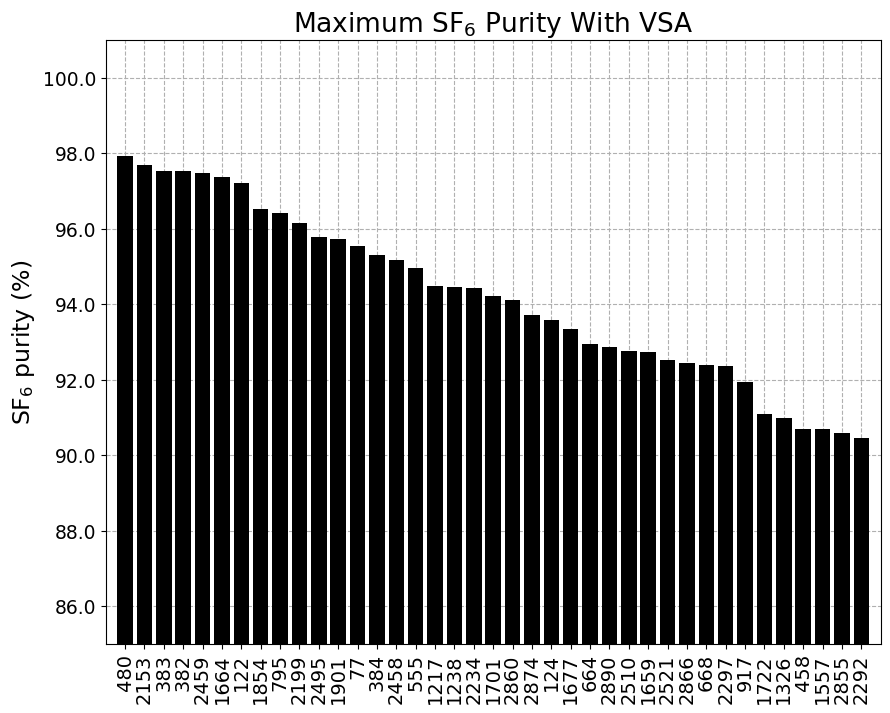

In [75]:
fig_xmax, ax_xmax = plt.subplots(figsize= [10,8],dpi = 100)
plt.grid(which = 'major', ls = '--')
ax_xmax.set_axisbelow(True)
ax_xmax.bar(np.arange(len(xx_max_so)),xx_max_so*100,
            color = 'k')

### x axis ###
ax_xmax.set_xticks(np.arange(len(Names_so)))
ax_xmax.set_xticklabels(Names_so,fontsize = 14,
                        rotation  = 90)
ax_xmax.set_title('Maximum SF$_6$ Purity With VSA ',fontsize = 19)
ax_xmax.set_xlim([-1,len(Names_so)])
#ax_xmax.set_xlabel('SF$_6$ purity (%)',fontsize=16)

### y axis ###
ax_xmax.set_ylim([85,101])
ax_xmax.set_ylabel('SF$_6$ purity (%)',fontsize=17)
ytick_xmax = ax_xmax.get_yticks()
ax_xmax.set_yticklabels(ytick_xmax,fontsize = 13.5)


# VSA Energy Consumption

In [80]:
gamma = 1.4
def VSA_E(Ph_in,Pl_in, T_in,eta_eff_in):
    P_ratio_term = (Ph_in/Pl_in)**((gamma-1)/gamma)-1
    E_comp = (gamma)/(gamma-1)*8.3145*T_in/eta_eff_in*P_ratio_term
    return E_comp
VSA_E(1,0.01,300,0.5)

47625.01377387299

In [83]:
from scipy.interpolate import interp1d

In [93]:
### CONDITIONS:
# T_feed_in, y_feed_in
eta_vac = 0.8

E_list = []
Pl_opt_list = []
cc = 0
for xxx in xx_list_so:
    f_int = interp1d(xxx,Pl_list)
    
    Pl_opt_tmp = f_int(0.9)
    E_tmp = VSA_E(1,Pl_opt_tmp,T_feed_in, eta_vac)
    Pl_opt_list.append(Pl_opt_tmp)
    E_list.append(E_tmp)
    
    print(Names_so[cc], ':', E_tmp)
    cc = cc + 1
    

480 : 19079.364621907698
2153 : 15128.473859087808
383 : 13882.12266773643
382 : 17030.486684079115
2459 : 19355.596249049966
1664 : 19565.315376767812
122 : 16090.208384136853
1854 : 19255.270465530153
795 : 17714.012335044627
2199 : 16282.448014208163
2495 : 18023.353096718012
1901 : 16173.219344156872
77 : 19419.293152931205
384 : 18294.051760150425
2458 : 19217.287370316553
555 : 18370.67578573334
1217 : 18008.5218751587
1238 : 19003.82904892609
2234 : 20330.544812546275
1701 : 19118.572482919302
2860 : 22220.319344654734
2874 : 26960.93084516807
124 : 24012.361669762406
1677 : 21018.598700897004
664 : 23527.905548097413
2890 : 23794.416160807505
2510 : 24177.783133764326
1659 : 23020.261169092693
2521 : 24229.428403205387
2866 : 28685.992336467527
668 : 24522.22054765841
2297 : 24585.181516075063
917 : 28787.818402326968
1722 : 32423.24594139271
1326 : 32483.137893702875
458 : 34757.32516347653
1557 : 37445.73627577594
2855 : 41358.95888912564
2292 : 41028.02968917592


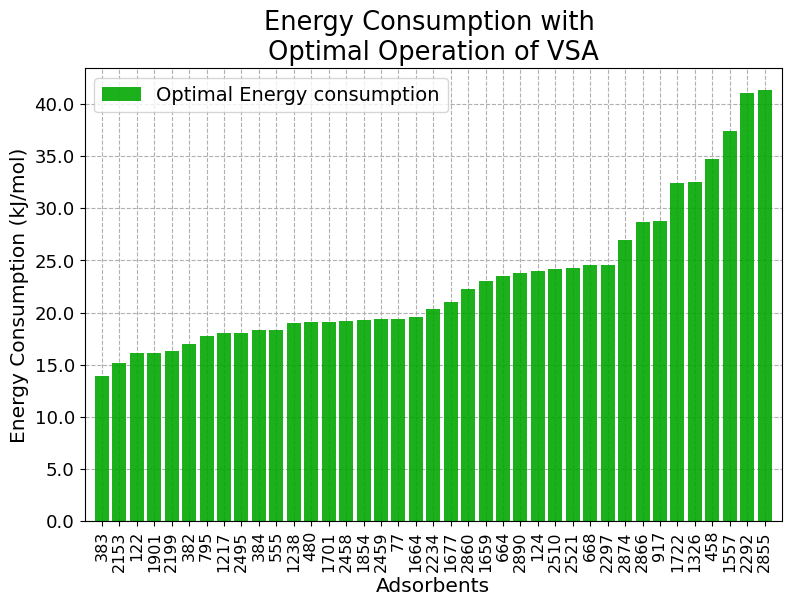

In [108]:
E_consu_arr = np.array(E_list)
E_consu_arr = np.reshape(E_consu_arr, [-1,])
arg_sort_e = np.argsort(E_consu_arr)

E_consu_sort = E_consu_arr[arg_sort_e]
Names_sort_e = Names_so[arg_sort_e]
dH_sort_e = dH_so[arg_sort_e]
bins_sort_e = bins_so[arg_sort_e]
Popt_sort_e = np.array(Pl_opt_list)[arg_sort_e]

fig_e, ax_e = plt.subplots(figsize = [9,6],dpi = 100)
plt.grid(which = 'major',linestyle  = '--')
ax_e.set_axisbelow(True)

bar1 = ax_e.bar(np.arange(len(E_consu_arr)),E_consu_sort/1000,
                color = [0,0.65,0], alpha = 0.89,
                label = 'Optimal Energy consumption')

ax_e.set_ylabel('Energy Consumption (kJ/mol)',fontsize = 14.5)
ax_e.set_xlabel('Adsorbents',fontsize = 14.5)

ax_e.set_title('Energy Consumption with \nOptimal Operation of VSA',fontsize = 18.5)
#ax_e.set_yticks([20,30,40,50,60,70,80,90,100])
#ax_e.set_yticklabels([20,30,40,50,60,70,80,90,100])

#ax_e.set_xlim([-2,len(E_consu_list)*1.01])
#ax_e.set_ylim([18,106])
#ax_e.set_xticks(np.arange(0,len(xx_xmax)))
ax_e.set_xticks(np.arange(len(Names_sort_e)))
ax_e.set_xticklabels(Names_sort_e,rotation = 90,fontsize= 11.5)
yticklab = ax_e.get_yticks()
ax_e.set_yticklabels(yticklab, fontsize = 13)

#ax_e.set_ylim([60,107])
ax_e.set_xlim([-1,len(E_consu_sort)])
frame1 = plt.gca()
#for xlabel_i in frame1.axes.get_xticklabels():
#    xlabel_i.set_visible(False)
#    xlabel_i.set_fontsize(0.0)

#for tick in frame1.axes.get_xticklines():
#    tick.set_visible(False)
    
plt.legend(fontsize = 14,loc = 'upper left')
plt.show()
#plt.figure(figsize =[9,6], dpi = 100)
#plt.bar(np.arange(len(xx_xmax)),xx_xmax, )